/home/nick/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Initial cost:  41.05505310046362
Final cost:  3.5239387203396446
Max absolute difference between the analytical solution and the network: 0.362021


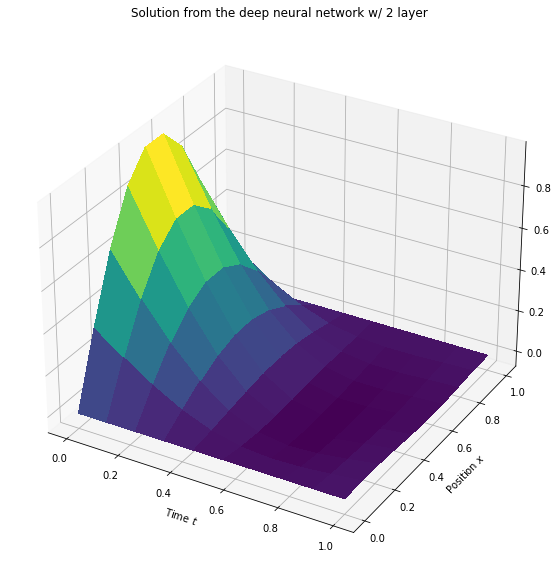

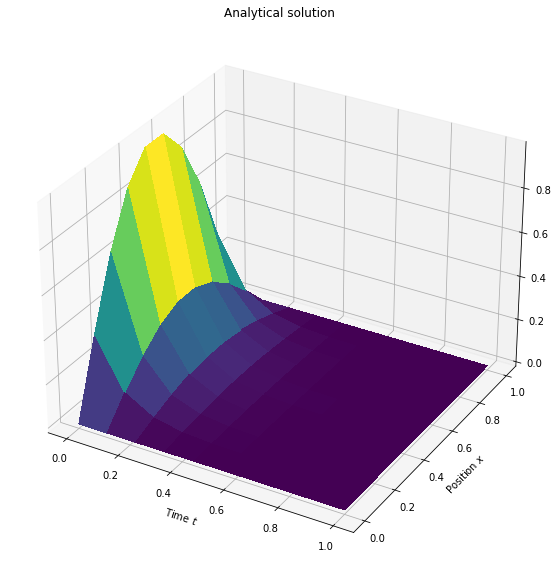

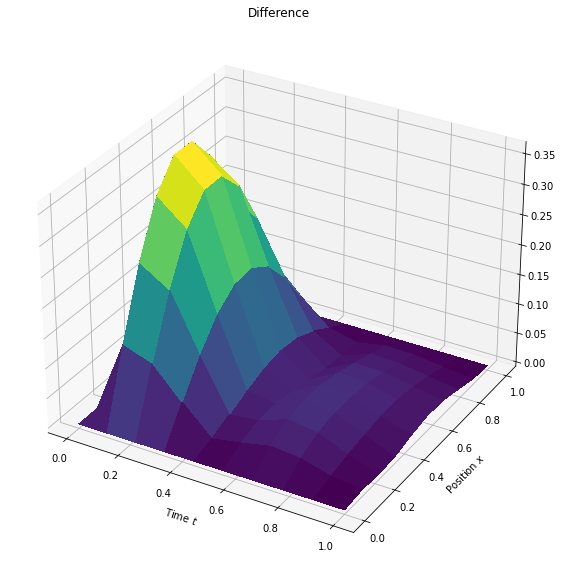

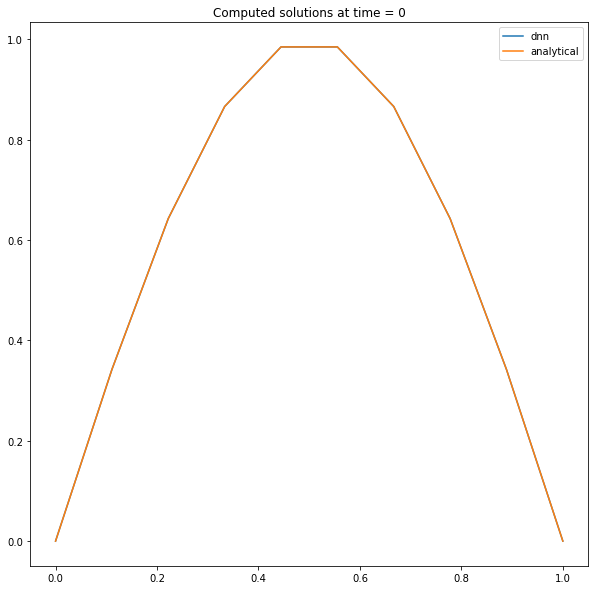

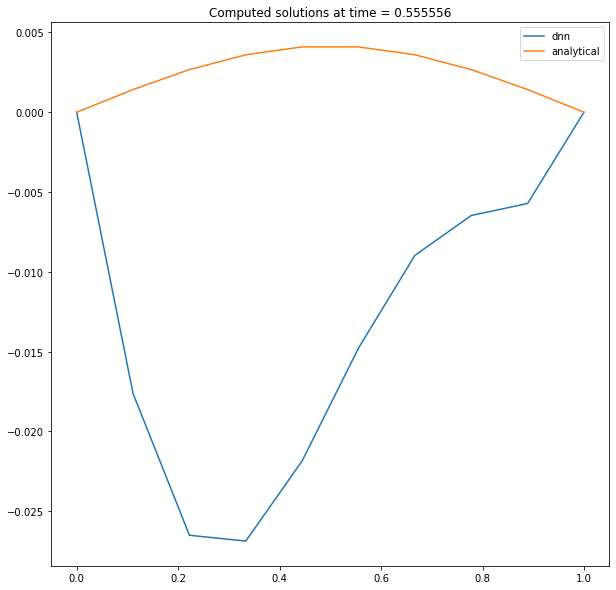

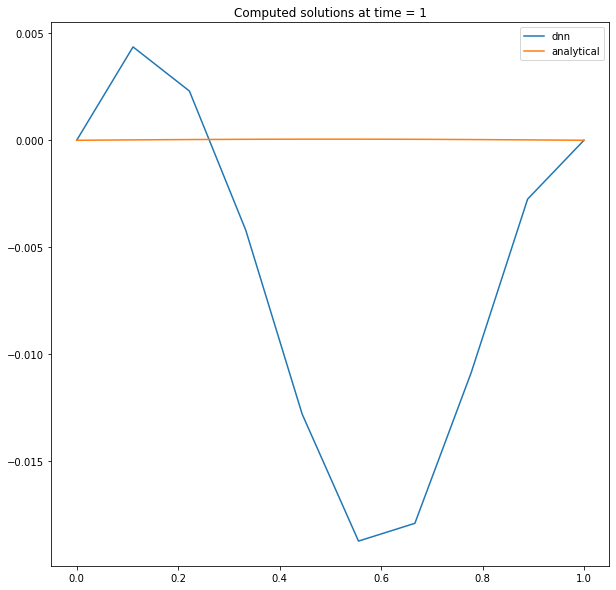

In [1]:
import autograd.numpy as np
from autograd import jacobian,hessian,grad
import autograd.numpy.random as npr
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Set up the network

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # x is now a point and a 1D numpy array; make it a column vector
    num_coordinates = np.size(x,0)
    x = x.reshape(num_coordinates,-1)

    num_points = np.size(x,1)

    # N_hidden is the number of hidden layers
    N_hidden = np.size(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assume that the input layer does nothing to the input x
    x_input = x
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_points)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_points)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output[0][0]

## Define the trial solution and cost function
def u(x):
    return np.sin(np.pi*x)

def g_trial(point,P):
    x,t = point
    return (1-t)*u(x) + x*(1-x)*t*deep_neural_network(P,point)

# The right side of the ODE:
def f(point):
    return 0.

# The cost function:
def cost_function(P, x, t):
    cost_sum = 0

    g_t_jacobian_func = jacobian(g_trial)
    g_t_hessian_func = hessian(g_trial)

    for x_ in x:
        for t_ in t:
            point = np.array([x_,t_])

            g_t = g_trial(point,P)
            g_t_jacobian = g_t_jacobian_func(point,P)
            g_t_hessian = g_t_hessian_func(point,P)

            g_t_dt = g_t_jacobian[1]
            g_t_d2x = g_t_hessian[0][0]

            func = f(point)

            err_sqr = ( (g_t_dt - g_t_d2x) - func)**2
            cost_sum += err_sqr

    return cost_sum /( np.size(x)*np.size(t) )

## For comparison, define the analytical solution
def g_analytic(point):
    x,t = point
    return np.exp(-np.pi**2*t)*np.sin(np.pi*x)

## Set up a function for training the network to solve for the equation
def solve_pde_deep_neural_network(x,t, num_neurons, num_iter, lmb):
    ## Set up initial weigths and biases
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 + 1 ) # 2 since we have two points, +1 to include bias
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: ',cost_function(P, x, t))

    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        cost_grad =  cost_function_grad(P, x , t)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_grad[l]

    print('Final cost: ',cost_function(P, x, t))

    return P

if __name__ == '__main__':
    ### Use the neural network:
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    Nx = 10; Nt = 10
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0,1,Nt)

    ## Set up the parameters for the network
    num_hidden_neurons = [100, 25]
    num_iter = 250
    lmb = 0.01

    P = solve_pde_deep_neural_network(x,t, num_hidden_neurons, num_iter, lmb)

    ## Store the results
    g_dnn_ag = np.zeros((Nx, Nt))
    G_analytical = np.zeros((Nx, Nt))
    for i,x_ in enumerate(x):
        for j, t_ in enumerate(t):
            point = np.array([x_, t_])
            g_dnn_ag[i,j] = g_trial(point,P)

            G_analytical[i,j] = g_analytic(point)

    # Find the map difference between the analytical and the computed solution
    diff_ag = np.abs(g_dnn_ag - G_analytical)
    print('Max absolute difference between the analytical solution and the network: %g'%np.max(diff_ag))

    ## Plot the solutions in two dimensions, that being in position and time

    T,X = np.meshgrid(t,x)

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_title('Solution from the deep neural network w/ %d layer'%len(num_hidden_neurons))
    s = ax.plot_surface(T,X,g_dnn_ag,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');


    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_title('Analytical solution')
    s = ax.plot_surface(T,X,G_analytical,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_title('Difference')
    s = ax.plot_surface(T,X,diff_ag,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

    ## Take some slices of the 3D plots just to see the solutions at particular times
    indx1 = 0
    indx2 = int(Nt/2)
    indx3 = Nt-1

    t1 = t[indx1]
    t2 = t[indx2]
    t3 = t[indx3]

    # Slice the results from the DNN
    res1 = g_dnn_ag[:,indx1]
    res2 = g_dnn_ag[:,indx2]
    res3 = g_dnn_ag[:,indx3]

    # Slice the analytical results
    res_analytical1 = G_analytical[:,indx1]
    res_analytical2 = G_analytical[:,indx2]
    res_analytical3 = G_analytical[:,indx3]

    # Plot the slices
    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t1)
    plt.plot(x, res1)
    plt.plot(x,res_analytical1)
    plt.legend(['dnn','analytical'])

    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t2)
    plt.plot(x, res2)
    plt.plot(x,res_analytical2)
    plt.legend(['dnn','analytical'])

    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t3)
    plt.plot(x, res3)
    plt.plot(x,res_analytical3)
    plt.legend(['dnn','analytical'])

    plt.show()